# Carregando dados das torres

**Rodar a célula abaixo carregará na memória as seguintes variáveis:**

**GPP das torres em resolução de 8D** -> observacoes_santarem, observacoes_peru, observacoes_caxiuana

**GPP das torres em resolução diária** --> observacoes_santarem_diario, observacoes_peru_diario, observacoes_caxiuana_diario

**GPP MODIS resolução 8D** -> gpp_modis_santarem, gpp_modis_peru, gpp_modis_caxiuana

**GPP MOD17 (MERRA-2) em resolução 8D** -> gpp_algpad_santarem, gpp_algpad_peru, gpp_algpad_caxiuana

**GPP MOD17 (MERRA-2) em resolução diária** -> gpp_algpad_santarem_diario, gpp_algpad_peru_diario, gpp_algpad_caxiuana_diario

**Drivers para cálculo do gpp com o algoritmo** -> drivers_santarem, drivers_peru, drivers_caxiuana

**Drivers mensais para calculo do GPP** -> drivers_santarem_mes, drivers_peru_mes, drivers_caxiuana_mes

**RMSEs das torres** -> rmse_modis_santarem, rmse_algpad_santarem, rmse_modis_peru, rmse_algpad_peru, rmse_modis_caxiuna, rmse_algpad_caxiuana

**RMSEs Mensais das torres** -> rmse_mes_algpad_santarem, rmse_mes_modis_santarem, rmse_mes_algpad_peru, rmse_mes_modis_peru, rmse_mes_algpad_caxiuana, rmse_mes_modis_caxiuana

**Indexs das series** -> index_santarem, index_peru, index_caxiuana

In [1]:
%run ./load_flux_towers_data.ipynb

# Importacoes

In [2]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import pandas as pd
from mod17 import MOD17
import matplotlib.pyplot as plt
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.sbx import SBX
from pymoo.util.display.column import Column
from pymoo.util.display.output import Output
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.sampling.lhs import LHS
from pymoo.operators.crossover.pntx import PointCrossover, SinglePointCrossover, TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.core.callback import Callback

# AG Options

In [3]:
pop_size = 3000
n_gen = 200
seed = 1
verbose = False
save_history = False

# Configurando a Otimizacao para Santarém

Otimizando o mês de: Janeiro
Otimizando o mês de: Fevereiro
Otimizando o mês de: Março
Otimizando o mês de: Abril
Otimizando o mês de: Maio
Otimizando o mês de: Junho
Otimizando o mês de: Julho
Otimizando o mês de: Agosto
Otimizando o mês de: Setembro
Otimizando o mês de: Outubro
Otimizando o mês de: Novembro
Otimizando o mês de: Dezembro
Janeiro       6.120705
Fevereiro     5.250784
Março         8.064120
Abril         7.918350
Maio         14.164698
Junho         9.280826
Julho         6.799619
Agosto        2.911993
Setembro     21.441547
Outubro      36.850924
Novembro     37.610358
Dezembro     28.884279
Name: RMSE, dtype: float64


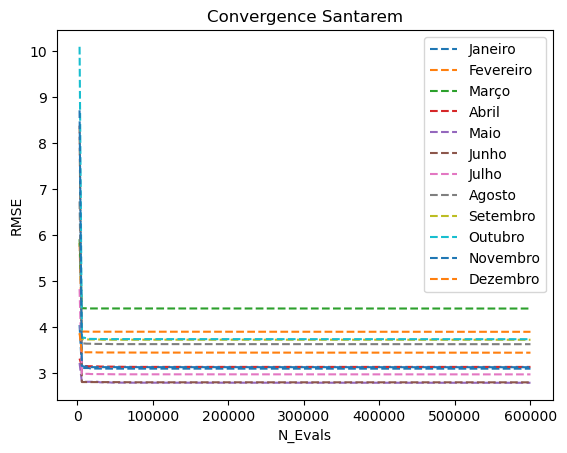

In [4]:
num_mes = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
nome_mes = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
rmse_mes_otimizado_santarem = np.zeros(12)

dados = pd.DataFrame()
for i in range(12):
    
      
    index_santarem_mes = index_santarem[index_santarem.month == i+1]
    observacoes_santarem_mes = observacoes_santarem_diario[observacoes_santarem_diario.index.month == i+1]
    def get_data(x):

        previsoes_santarem = MOD17._gpp(x, drivers_santarem_mes['arr_'+str(i)][0], drivers_santarem_mes['arr_'+str(i)][1], drivers_santarem_mes['arr_'+str(i)][2], drivers_santarem_mes['arr_'+str(i)][3])
        previsoes_santarem = pd.DataFrame(previsoes_santarem,index=index_santarem_mes)
        
        return previsoes_santarem


    class MyCustomProblem(ElementwiseProblem,):
        def __init__(self):
            super().__init__(
                n_var=5,
                n_obj=1,
                n_constr=1,
                xl=np.array([0.3 / 1000, -35, 6, 60, 1500]),
                xu=np.array([3.0 / 1000, -2, 30, 1000, 6500]),
            )

        def _evaluate(self, x, out, *args, **kwargs):
            global observacoes_santarem_mes
            
            previsoes_santarem = get_data(x)
            
            rmse_santarem = np.sqrt(mean_squared_error(y_true=observacoes_santarem_mes, y_pred=previsoes_santarem))

            # Armazene os valores da função de aptidão e da restrição na saída
            out["F"] = rmse_santarem
        

    class MyOutput(Output):

        def __init__(self):
            super().__init__()
            self.LUEmax = Column("LUEmax", width=13)
            self.Tmin_min = Column("Tmin_min", width=13)
            self.Tmin_max = Column("Tmin_max", width=13)
            self.VPD_min = Column("VPD_min", width=13)
            self.VPD_max = Column("VPD_max", width=13)
            self.RMSE_Sant = Column("RMSE Sant "+ nome_mes[i], width=13)
            self.columns += [self.LUEmax, self.Tmin_min,self.Tmin_max,self.VPD_min,self.VPD_max,self.RMSE_Sant]


        def update(self, algorithm):

            super().update(algorithm)
            self.LUEmax.set(algorithm.pop.get("X")[0][0])
            self.Tmin_min.set(algorithm.pop.get("X")[0][1])
            self.Tmin_max.set(algorithm.pop.get("X")[0][2])
            self.VPD_min.set(algorithm.pop.get("X")[0][3])
            self.VPD_max.set(algorithm.pop.get("X")[0][4])

            self.RMSE_Sant.set(algorithm.pop.get("F")[0][0])

    class MyCallback(Callback):

        def __init__(self) -> None:
            super().__init__()
            self.n_evals = []
            self.opt = []

        def notify(self, algorithm):
            self.n_evals.append(algorithm.evaluator.n_eval)
            self.opt.append(algorithm.opt[0].F)

    # Defina o problema
    problem = MyCustomProblem()

    sampling = LHS()

    algorithm = GA(
        pop_size=pop_size,
        eliminate_duplicates=True,
        sampling=sampling(problem, pop_size).get("X"),
        mutation=PolynomialMutation(prob=0.7),
        crossover=SinglePointCrossover(prob=0.5)
    )
    print('Otimizando o mês de: ' + nome_mes[i])
    # Execute a otimização
    callback = MyCallback()
    res = minimize(problem,
                    algorithm,
                    ('n_gen', n_gen),
                    seed=seed,
                    output=MyOutput(),
                    callback=callback,
                    save_history=save_history,
                    verbose=verbose)
    


    plt.title("Convergence Santarem")
    plt.plot(callback.n_evals, callback.opt, "--")
    plt.ylabel("RMSE")
    plt.xlabel("N_Evals")
    plt.legend(nome_mes, loc=1)
    #plt.show()
    dados_mes = {"RMSE" : res.pop.get("F")[0][0],
                "LUE_Max" : res.pop.get("X")[0][0],
                "Tmin_min" : res.pop.get("X")[0][1],
                "Tmin_max" : res.pop.get("X")[0][2],
                "VPD_min" : res.pop.get("X")[0][3],
                "VPD_max" : res.pop.get("X")[0][4],
                "N_Pop" : pop_size,
                "N_ger" : n_gen,
                "Seed" : seed,
                "Melhora %": ((rmse_mes_algpad_santarem_diario[i] - res.pop.get("F")[0][0])/np.abs(rmse_mes_algpad_santarem_diario[i]))*100,
                "Tempo_Exec(s)": res.exec_time}
    dados_mes = pd.DataFrame(dados_mes, index=[nome_mes[i]])
    dados = pd.concat([dados,dados_mes], axis=0)
plt.savefig('convergence_santarem.png', dpi=150)
dados.to_csv('GA_Santarem.csv', index_label="Month")
print(((rmse_mes_algpad_santarem_diario - dados['RMSE'])/np.abs(rmse_mes_algpad_santarem_diario))*100)

# Configurando a Otimização para o Peru

Otimizando o mês de: Janeiro
Otimizando o mês de: Fevereiro
Otimizando o mês de: Março
Otimizando o mês de: Abril
Otimizando o mês de: Maio
Otimizando o mês de: Junho
Otimizando o mês de: Julho
Otimizando o mês de: Agosto
Otimizando o mês de: Setembro
Otimizando o mês de: Outubro
Otimizando o mês de: Novembro
Otimizando o mês de: Dezembro
Janeiro      36.536761
Fevereiro    41.473455
Março        37.113098
Abril        19.501252
Maio         13.763238
Junho        12.763306
Julho        24.005846
Agosto       21.842004
Setembro     23.265222
Outubro      31.269265
Novembro     29.340697
Dezembro     28.938367
Name: RMSE, dtype: float64


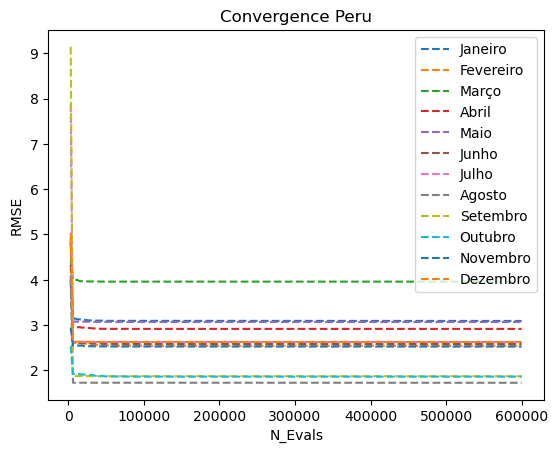

In [5]:
num_mes = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
nome_mes = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
rmse_mes_otimizado_peru = np.zeros(12)

dados = pd.DataFrame()
for i in range(12):

    observacoes_peru_mes = observacoes_peru_diario[observacoes_peru_diario.index.month == i+1]
    

    def get_data(x):

        previsoes_peru = MOD17._gpp(x, drivers_peru_mes['arr_'+str(i)][0], drivers_peru_mes['arr_'+str(i)][1], drivers_peru_mes['arr_'+str(i)][2], drivers_peru_mes['arr_'+str(i)][3])
        previsoes_peru = pd.DataFrame(previsoes_peru,index=index_peru[index_peru.month == i+1])

        return previsoes_peru


    class MyCustomProblem(ElementwiseProblem,):
        def __init__(self):
            super().__init__(
                n_var=5,
                n_obj=1,
                n_constr=1,
                xl=np.array([0.3 / 1000, -35, 6, 60, 1500]),
                xu=np.array([3.0 / 1000, -2, 30, 1000, 6500]),
            )

        def _evaluate(self, x, out, *args, **kwargs):

            global observacoes_peru_mes

            previsoes_peru = get_data(x)

            rmse_peru = np.sqrt(mean_squared_error(y_true=observacoes_peru_mes, y_pred=previsoes_peru))

            # Armazene os valores da função de aptidão e da restrição na saída
            out["F"] = rmse_peru
        

    class MyOutput(Output):

        def __init__(self):
            super().__init__()
            self.LUEmax = Column("LUEmax", width=13)
            self.Tmin_min = Column("Tmin_min", width=13)
            self.Tmin_max = Column("Tmin_max", width=13)
            self.VPD_min = Column("VPD_min", width=13)
            self.VPD_max = Column("VPD_max", width=13)
            self.RMSE_Peru = Column("RMSE Peru "+ nome_mes[i], width=13)
            self.columns += [self.LUEmax, self.Tmin_min,self.Tmin_max,self.VPD_min,self.VPD_max,self.RMSE_Peru]


        def update(self, algorithm):
                
            super().update(algorithm)
            self.LUEmax.set(algorithm.pop.get("X")[0][0])
            self.Tmin_min.set(algorithm.pop.get("X")[0][1])
            self.Tmin_max.set(algorithm.pop.get("X")[0][2])
            self.VPD_min.set(algorithm.pop.get("X")[0][3])
            self.VPD_max.set(algorithm.pop.get("X")[0][4])

            self.RMSE_Peru.set(algorithm.pop.get("F")[0][0])

    class MyCallback(Callback):

        def __init__(self) -> None:
            super().__init__()
            self.n_evals = []
            self.opt = []

        def notify(self, algorithm):
            self.n_evals.append(algorithm.evaluator.n_eval)
            self.opt.append(algorithm.opt[0].F)

    # Defina o problema
    problem = MyCustomProblem()

    sampling = LHS()

    algorithm = GA(
        pop_size=pop_size,
        eliminate_duplicates=True,
        sampling=sampling(problem, pop_size).get("X"),
        mutation=PolynomialMutation(prob=0.7),
        crossover=SinglePointCrossover(prob=0.5)
    )

    print('Otimizando o mês de: ' + nome_mes[i])
    # Execute a otimização
    callback = MyCallback()
    res = minimize(problem,
                    algorithm,
                    ('n_gen', n_gen),
                    seed=seed,
                    output=MyOutput(),
                    callback=callback,
                    save_history=save_history,
                    verbose=verbose)


    plt.title("Convergence Peru")
    plt.plot(callback.n_evals, callback.opt, "--")
    plt.ylabel("RMSE")
    plt.xlabel("N_Evals")
    plt.legend(nome_mes, loc=1)
    #plt.show()
    dados_mes = {"RMSE" : res.pop.get("F")[0][0],
                "LUE_Max" : res.pop.get("X")[0][0],
                "Tmin_min" : res.pop.get("X")[0][1],
                "Tmin_max" : res.pop.get("X")[0][2],
                "VPD_min" : res.pop.get("X")[0][3],
                "VPD_max" : res.pop.get("X")[0][4],
                "N_Pop" : pop_size,
                "N_ger" : n_gen,
                "Seed" : seed,
                "Melhora %": ((rmse_mes_algpad_peru_diario[i] - res.pop.get("F")[0][0])/np.abs(rmse_mes_algpad_peru_diario[i]))*100,
                "Tempo_Exec(s)": res.exec_time}
    dados_mes = pd.DataFrame(dados_mes, index=[nome_mes[i]])
    dados = pd.concat([dados,dados_mes], axis=0)

plt.savefig('convergence_peru.png', dpi=150)
dados.to_csv('GA_Peru.csv', index_label="Month")
print(((rmse_mes_algpad_peru_diario - dados['RMSE'])/np.abs(rmse_mes_algpad_peru_diario))*100)

# Configurando a Otimizacao para Caxiuana

Otimizando o mês de: Janeiro
Otimizando o mês de: Fevereiro
Otimizando o mês de: Março
Otimizando o mês de: Abril
Otimizando o mês de: Maio
Otimizando o mês de: Junho
Otimizando o mês de: Julho
Otimizando o mês de: Agosto
Otimizando o mês de: Setembro
Otimizando o mês de: Outubro
Otimizando o mês de: Novembro
Otimizando o mês de: Dezembro
Janeiro      21.065504
Fevereiro    23.064075
Março        40.032948
Abril        34.955151
Maio         33.047495
Junho        33.549221
Julho        10.700552
Agosto        3.869901
Setembro     34.584453
Outubro      54.774692
Novembro     54.471240
Dezembro     18.714973
Name: RMSE, dtype: float64


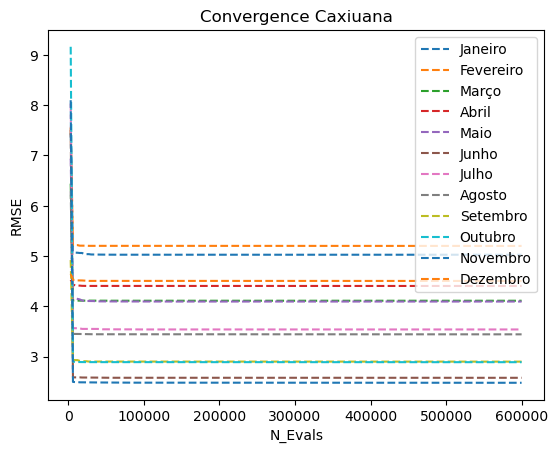

In [6]:
num_mes = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
nome_mes = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
rmse_mes_otimizado_caxiuana = np.zeros(12)
dados = pd.DataFrame()
for i in range(12):

    observacoes_caxiuana_mes = observacoes_caxiuana_diario[observacoes_caxiuana_diario.index.month == i+1]
    

    def get_data(x):

        previsoes_caxiuana = MOD17._gpp(x, drivers_caxiuana_mes['arr_'+str(i)][0], drivers_caxiuana_mes['arr_'+str(i)][1], drivers_caxiuana_mes['arr_'+str(i)][2], drivers_caxiuana_mes['arr_'+str(i)][3])
        previsoes_caxiuana = pd.DataFrame(previsoes_caxiuana,index=index_caxiuana[index_caxiuana.month == i+1])

        return previsoes_caxiuana


    class MyCustomProblem(ElementwiseProblem,):
        def __init__(self):
            super().__init__(
                n_var=5,
                n_obj=1,
                n_constr=1,
                xl=np.array([0.3 / 1000, -35, 6, 60, 1500]),
                xu=np.array([3.0 / 1000, -2, 30, 1000, 6500]),
            )

        def _evaluate(self, x, out, *args, **kwargs):

            global observacoes_caxiuana_mes

            previsoes_caxiuana = get_data(x)

            rmse_caxiuana = np.sqrt(mean_squared_error(y_true=observacoes_caxiuana_mes, y_pred=previsoes_caxiuana))

            # Armazene os valores da função de aptidão e da restrição na saída
            out["F"] = rmse_caxiuana
        

    class MyOutput(Output):

        def __init__(self):
            super().__init__()
            self.LUEmax = Column("LUEmax", width=13)
            self.Tmin_min = Column("Tmin_min", width=13)
            self.Tmin_max = Column("Tmin_max", width=13)
            self.VPD_min = Column("VPD_min", width=13)
            self.VPD_max = Column("VPD_max", width=13)
            self.RMSE_caxiuana = Column("RMSE caxiuana "+ nome_mes[i], width=13)
            self.columns += [self.LUEmax, self.Tmin_min,self.Tmin_max,self.VPD_min,self.VPD_max,self.RMSE_caxiuana]


        def update(self, algorithm):

            super().update(algorithm)
            self.LUEmax.set(algorithm.pop.get("X")[0][0])
            self.Tmin_min.set(algorithm.pop.get("X")[0][1])
            self.Tmin_max.set(algorithm.pop.get("X")[0][2])
            self.VPD_min.set(algorithm.pop.get("X")[0][3])
            self.VPD_max.set(algorithm.pop.get("X")[0][4])

            self.RMSE_caxiuana.set(algorithm.pop.get("F")[0][0])

    class MyCallback(Callback):

        def __init__(self) -> None:
            super().__init__()
            self.n_evals = []
            self.opt = []

        def notify(self, algorithm):
            self.n_evals.append(algorithm.evaluator.n_eval)
            self.opt.append(algorithm.opt[0].F)

    # Defina o problema
    problem = MyCustomProblem()

    sampling = LHS()

    algorithm = GA(
        pop_size=pop_size,
        eliminate_duplicates=True,
        sampling=sampling(problem, pop_size).get("X"),
        mutation=PolynomialMutation(prob=0.7),
        crossover=SinglePointCrossover(prob=0.5)
    )
    print('Otimizando o mês de: ' + nome_mes[i])
    # Execute a otimização
    callback = MyCallback()
    res = minimize(problem,
                    algorithm,
                    ('n_gen', n_gen),
                    seed=seed,
                    output=MyOutput(),
                    callback=callback,
                    save_history=save_history,
                    verbose=verbose)

    plt.title("Convergence Caxiuana")
    plt.plot(callback.n_evals, callback.opt, "--")
    plt.ylabel("RMSE")
    plt.xlabel("N_Evals")
    plt.legend(nome_mes, loc=1)
    #plt.show()
    dados_mes = {"RMSE" : res.pop.get("F")[0][0],
                "LUE_Max" : res.pop.get("X")[0][0],
                "Tmin_min" : res.pop.get("X")[0][1],
                "Tmin_max" : res.pop.get("X")[0][2],
                "VPD_min" : res.pop.get("X")[0][3],
                "VPD_max" : res.pop.get("X")[0][4],
                "N_Pop" : pop_size,
                "N_ger" : n_gen,
                "Seed" : seed,
                "Melhora %": ((rmse_mes_algpad_caxiuana_diario[i] - res.pop.get("F")[0][0])/np.abs(rmse_mes_algpad_caxiuana_diario[i]))*100,
                "Tempo_Exec(s)": res.exec_time}
    dados_mes = pd.DataFrame(dados_mes, index=[nome_mes[i]])
    dados = pd.concat([dados,dados_mes], axis=0)
plt.savefig('convergence_caxiuana.png', dpi=150)
dados.to_csv('GA_Caxiuana.csv', index_label="Month")
print(((rmse_mes_algpad_caxiuana_diario - dados['RMSE'])/np.abs(rmse_mes_algpad_caxiuana_diario))*100)